In [1]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from random import sample

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import pickle

import pandas as pd
from openpyxl import load_workbook

import xgboost as xgb

print(tf.__version__)
print(device_lib.list_local_devices())

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 63170929933577203
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8862654270588520582
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import xgboost as xgb
# import xgboost as xgb

# model_1.save_model('model_1.model')
# model_2_v2 = xgb.train(params, xg_train_2, 30, xgb_model='model_1.model')


In [24]:
def get_action(xgbmodel, state, eps, is_greedy):
    input = xgb.DMatrix(state.reshape([-1,4]))
    if is_greedy:
        if xgbmodel.predict(input) > 0.5:
            a = 1
        else:
            a = 0
        return a
    else:
        if np.random.choice([True, False],p = [eps,1-eps]):
            a = np.random.choice(2,p = [0.5,0.5])
        else:
            if xgbmodel.predict(input) > 0.5:
                a = 1
            else:
                a = 0
        return a


def make_model(states, actions, model_name):
    x = np.concatenate(states, axis = 0).reshape([-1,4])
    y = np.array(actions).reshape([-1,1])
    dtrain = xgb.DMatrix(x, y)
    if model_name == None:
        model = xgb.train(params, dtrain)
    else:
        model = xgb.train(params, dtrain, xgb_model=model_name)
    return model




In [25]:
%%time
params = {
    "tree_method": "hist", 
          "objective": 'binary:logistic',
        # "objective": 'multi:softprob',
        
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "single_precision_histogram" : True,
          }

env = gym.make('CartPole-v1')

xgb_clf = make_model([[0,0,0,0]],[[1]], model_name=None)
xgb_clf.save_model("model.json")
cumr_history = []
epsilon = 1
avg = 8

for _ in range(100):  # 배치학습
    if _%50 == 0:
        print(f"episode: {_}")
        print(f"최근 10 에피소드 평균점수: {avg}")
    total_r_list = []
    states_list = []
    actions_list = []
    

    for _ in range(10):
        epsilon*=0.95

        states = []
        actions = []
        total_r = 0
        s = env.reset()
        a = get_action(xgb_clf,s,epsilon, is_greedy=False)

        states.append(s)
        actions.append(a)
        while True:
            ns, r, done, _ = env.step(a)
            total_r += r
            done = 1 if done else 0


            if done == 1:
                s = env.reset()
                # env.render()
                a = get_action(xgb_clf,s,epsilon, is_greedy=False)
                states.append(s)
                actions.append(a)
                total_r_list.append(total_r)
                states_list.append(states)
                actions_list.append(actions)
                cumr_history.append(total_r)
                break
            else:
                s = ns
                a = get_action(xgb_clf,s,epsilon, is_greedy=False)
                states.append(s)
                actions.append(a)

    

    train_x = []
    train_y = []
    avg = sum(total_r_list)/len(total_r_list)
    # print(f"최근 10 에피소드 평균점수: {avg}") if avg < 250 else print(f"최근 10 에피소드 평균점수: {avg} --학습완료--")
    if avg > 250:
        print(f"최근 10 에피소드 평균점수: {avg} --학습완료--")
        break

    for i in range(len(total_r_list)):
        if total_r_list[i] > avg:

            train_x.extend(states_list[i])
            train_y.extend(actions_list[i])

    
    xgb_clf = make_model(train_x,train_y,"model.json")
            


    ###평균보다 크면 리스트에남기고 작으면 없애고 모델 새로만들기

episode: 0
최근 10 에피소드 평균점수: 8
최근 10 에피소드 평균점수: 355.8 --학습완료--
CPU times: total: 1min 18s
Wall time: 6.32 s


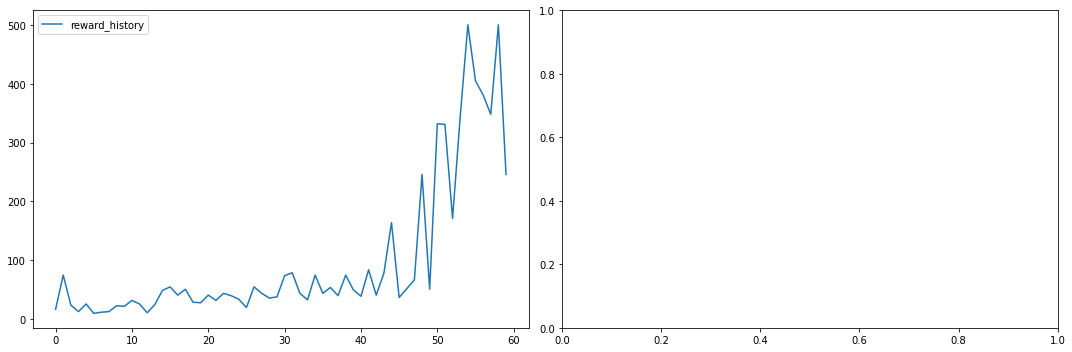

In [26]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(cumr_history, label='reward_history')
axes[0].legend()
# axes[1].plot(critic_loss_list, label='critic loss')
# axes[1].legend()
# axes[2].plot(cur_list, label='cumulated reward history')
# axes[2].legend()
# axes[2].hist(cur_list, density=True, label='only_online_awac')
# axes[2].legend()
fig.tight_layout()

* test

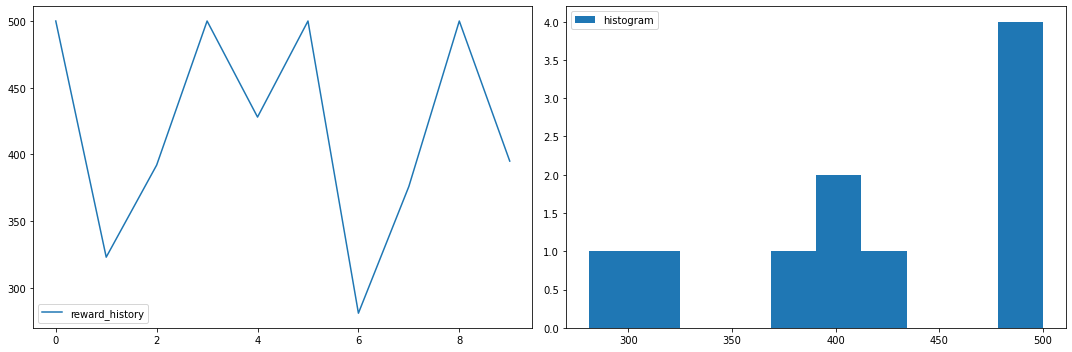

In [28]:
rewards = []
env = gym.make('CartPole-v1')

for _ in range(10):
    total_r = 0
    s = env.reset()
    # env.render()
    a = get_action(xgb_clf,s,epsilon, is_greedy=True)
    while True:
        ns, r, done, _ = env.step(a)
        # env.render()
        total_r += r
        done = 1 if done else 0


        if done == 1:
            s = env.reset()
            # env.render()
            a = get_action(xgb_clf,s,epsilon, is_greedy=True)
            rewards.append(total_r)
          
            break
        else:
            s = ns
            a = get_action(xgb_clf,s,epsilon, is_greedy=True)

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(rewards, label='reward_history')
axes[0].legend()
axes[1].hist(rewards, label='histogram')
axes[1].legend()
# axes[2].plot(cur_list, label='cumulated reward history')
# axes[2].legend()
# axes[2].hist(cur_list, density=True, label='only_online_awac')
# axes[2].legend()
fig.tight_layout()
            